In [1]:
# --- Lab: XGBoost — Classification & Regression ---
# Goal: Learn key XGBoost techniques — early stopping, feature importances, tuning, and validation.

# ========== 0. Installation & Imports ==========
%pip install -q xgboost

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer, fetch_california_housing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import (
    accuracy_score, roc_auc_score, ConfusionMatrixDisplay, classification_report,
    mean_absolute_error, r2_score
)
from xgboost import XGBClassifier, XGBRegressor, plot_importance
import joblib
%matplotlib inline

print("Libraries imported successfully.")


Note: you may need to restart the kernel to use updated packages.
Libraries imported successfully.


In [2]:
# ========== 1. Classification: Breast Cancer dataset ==========
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name='target')

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Dataset shape:", X.shape)
display(X.head())


Dataset shape: (569, 30)


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


[0]	validation_0-auc:0.97305
[1]	validation_0-auc:0.98578
[2]	validation_0-auc:0.99339
[3]	validation_0-auc:0.99471
[4]	validation_0-auc:0.99438
[5]	validation_0-auc:0.99405
[6]	validation_0-auc:0.99603
[7]	validation_0-auc:0.99537
[8]	validation_0-auc:0.99471
[9]	validation_0-auc:0.99504
[10]	validation_0-auc:0.99537
[11]	validation_0-auc:0.99504
[12]	validation_0-auc:0.99471
[13]	validation_0-auc:0.99438
[14]	validation_0-auc:0.99372
[15]	validation_0-auc:0.99306
[16]	validation_0-auc:0.99372
[17]	validation_0-auc:0.99405
[18]	validation_0-auc:0.99438
[19]	validation_0-auc:0.99405
[20]	validation_0-auc:0.99438
[21]	validation_0-auc:0.99438
[22]	validation_0-auc:0.99405
[23]	validation_0-auc:0.99405
[24]	validation_0-auc:0.99504
[25]	validation_0-auc:0.99405
[26]	validation_0-auc:0.99471
[27]	validation_0-auc:0.99438
[28]	validation_0-auc:0.99504
[29]	validation_0-auc:0.99537
[30]	validation_0-auc:0.99471
[31]	validation_0-auc:0.99438
[32]	validation_0-auc:0.99438
[33]	validation_0-au

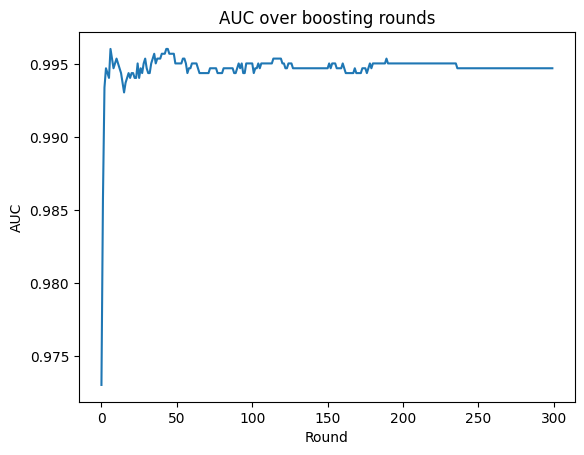

In [3]:
# ========== 2. Base XGBClassifier + Early Stopping ==========
clf = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="auc",
    n_jobs=-1,
    random_state=42
)

clf.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    verbose=True
)

# Access training results
results = clf.evals_result()
plt.plot(results['validation_0']['auc'])
plt.title("AUC over boosting rounds")
plt.xlabel("Round")
plt.ylabel("AUC")
plt.show()


In [4]:
# ========== Task 1: Parameter Experiment ==========
# Try modifying learning_rate, max_depth, subsample, colsample_bytree
exp = XGBClassifier(
    n_estimators=1500,
    learning_rate=0.07,
    max_depth=5,
    subsample=0.9,
    colsample_bytree=0.9,
    eval_metric="auc",
    n_jobs=-1,
    random_state=42
)

# Fit without early stopping
exp.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    verbose=True
)

# Predict and evaluate
proba_exp = exp.predict_proba(X_valid)[:, 1]
print("Valid ROC-AUC:", round(roc_auc_score(y_valid, proba_exp), 4))


[0]	validation_0-auc:0.96991
[1]	validation_0-auc:0.98462
[2]	validation_0-auc:0.99223
[3]	validation_0-auc:0.99190
[4]	validation_0-auc:0.99190
[5]	validation_0-auc:0.99223
[6]	validation_0-auc:0.99339
[7]	validation_0-auc:0.99206
[8]	validation_0-auc:0.99306
[9]	validation_0-auc:0.99173
[10]	validation_0-auc:0.99206
[11]	validation_0-auc:0.99008
[12]	validation_0-auc:0.98942
[13]	validation_0-auc:0.99008
[14]	validation_0-auc:0.99041
[15]	validation_0-auc:0.99107
[16]	validation_0-auc:0.99206
[17]	validation_0-auc:0.99206
[18]	validation_0-auc:0.99272
[19]	validation_0-auc:0.99239
[20]	validation_0-auc:0.99239
[21]	validation_0-auc:0.99206
[22]	validation_0-auc:0.99173
[23]	validation_0-auc:0.99239
[24]	validation_0-auc:0.99272
[25]	validation_0-auc:0.99306
[26]	validation_0-auc:0.99339
[27]	validation_0-auc:0.99372
[28]	validation_0-auc:0.99372
[29]	validation_0-auc:0.99306
[30]	validation_0-auc:0.99272
[31]	validation_0-auc:0.99272
[32]	validation_0-auc:0.99272
[33]	validation_0-au

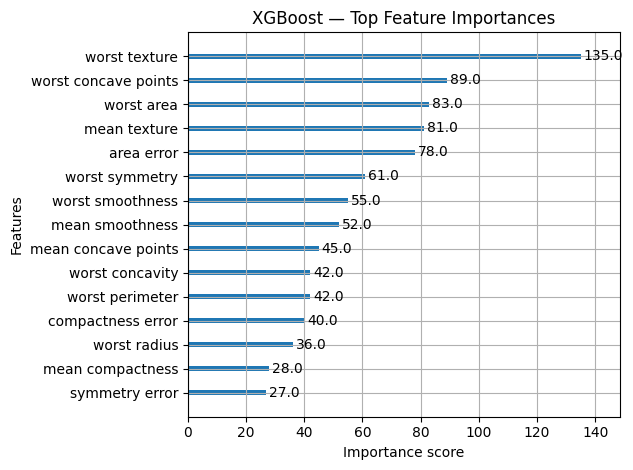

worst radius            0.205715
mean concave points     0.153326
worst perimeter         0.138093
worst concave points    0.126858
worst area              0.089740
mean area               0.021601
worst concavity         0.021508
mean perimeter          0.020963
texture error           0.020783
concavity error         0.019321
dtype: float32

In [5]:
# ========== 3. Feature Importances ==========
plot_importance(clf, max_num_features=15)
plt.title("XGBoost — Top Feature Importances")
plt.tight_layout()
plt.show()

pd.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=False).head(10)


In [6]:
# ========== 4. Cross-validation and Mini GridSearch ==========
cv_scores = cross_val_score(
    XGBClassifier(
        n_estimators=400, learning_rate=0.1, max_depth=4,
        subsample=0.8, colsample_bytree=0.8,
        eval_metric="auc", n_jobs=-1, random_state=42
    ),
    X, y, scoring="roc_auc", cv=5, n_jobs=-1
)
print("CV ROC-AUC mean ± std:", round(cv_scores.mean(), 4), "±", round(cv_scores.std(), 4))


CV ROC-AUC mean ± std: 0.9929 ± 0.0059


In [7]:
# ========== 5. Regression: California Housing ==========
cal = fetch_california_housing(as_frame=True)
Xr = cal.data
yr = cal.target

Xr_train, Xr_valid, yr_train, yr_valid = train_test_split(
    Xr, yr, test_size=0.2, random_state=42
)

print("Regression dataset shape:", Xr.shape)
display(Xr.head())


Regression dataset shape: (20640, 8)


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [8]:
# ========== 6. XGBRegressor (Compatible with older XGBoost) ==========
reg = XGBRegressor(
    n_estimators=1500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    n_jobs=-1,
    random_state=42,
    eval_metric="rmse"  
)

# Fit without early stopping
reg.fit(
    Xr_train, yr_train,
    eval_set=[(Xr_valid, yr_valid)],
    verbose=True
)

# Evaluate
predr = reg.predict(Xr_valid)
print("MAE:", round(mean_absolute_error(yr_valid, predr), 4))
print("R2 :", round(r2_score(yr_valid, predr), 4))


[0]	validation_0-rmse:1.10752
[1]	validation_0-rmse:1.08065
[2]	validation_0-rmse:1.05084
[3]	validation_0-rmse:1.01808
[4]	validation_0-rmse:0.99223
[5]	validation_0-rmse:0.96429
[6]	validation_0-rmse:0.93880
[7]	validation_0-rmse:0.91365
[8]	validation_0-rmse:0.89213
[9]	validation_0-rmse:0.87647
[10]	validation_0-rmse:0.85707
[11]	validation_0-rmse:0.83877
[12]	validation_0-rmse:0.82205
[13]	validation_0-rmse:0.80968
[14]	validation_0-rmse:0.79178
[15]	validation_0-rmse:0.77525
[16]	validation_0-rmse:0.76233
[17]	validation_0-rmse:0.74891
[18]	validation_0-rmse:0.73555
[19]	validation_0-rmse:0.72267
[20]	validation_0-rmse:0.71099
[21]	validation_0-rmse:0.70019
[22]	validation_0-rmse:0.68996
[23]	validation_0-rmse:0.67965
[24]	validation_0-rmse:0.67112
[25]	validation_0-rmse:0.66288
[26]	validation_0-rmse:0.65411
[27]	validation_0-rmse:0.64697
[28]	validation_0-rmse:0.63965
[29]	validation_0-rmse:0.63340
[30]	validation_0-rmse:0.62643
[31]	validation_0-rmse:0.62073
[32]	validation_0-

In [9]:
# ========== Task 2: Parameter tuning (Regression, old XGBoost compatible) ==========
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# Модель с параметрами
exp_reg = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.07,
    max_depth=5,
    subsample=0.9,
    colsample_bytree=0.9,
    n_jobs=-1,
    random_state=42,
    eval_metric="rmse"   # указываем метрику здесь, а не в .fit()
)

# Обучение без early_stopping (он не работает в старой версии)
exp_reg.fit(Xr_train, yr_train, eval_set=[(Xr_valid, yr_valid)], verbose=True)

# Предсказание
pred_exp = exp_reg.predict(Xr_valid)

# Оценка
print("MAE:", round(mean_absolute_error(yr_valid, pred_exp), 4))
print("R2 :", round(r2_score(yr_valid, pred_exp), 4))


[0]	validation_0-rmse:1.09671
[1]	validation_0-rmse:1.06163
[2]	validation_0-rmse:1.02029
[3]	validation_0-rmse:0.98201
[4]	validation_0-rmse:0.94906
[5]	validation_0-rmse:0.91831
[6]	validation_0-rmse:0.88926
[7]	validation_0-rmse:0.86227
[8]	validation_0-rmse:0.83910
[9]	validation_0-rmse:0.81694
[10]	validation_0-rmse:0.79701
[11]	validation_0-rmse:0.77871
[12]	validation_0-rmse:0.76245
[13]	validation_0-rmse:0.74747
[14]	validation_0-rmse:0.73404
[15]	validation_0-rmse:0.72222
[16]	validation_0-rmse:0.71170
[17]	validation_0-rmse:0.70154
[18]	validation_0-rmse:0.69115
[19]	validation_0-rmse:0.67710
[20]	validation_0-rmse:0.66856
[21]	validation_0-rmse:0.65956
[22]	validation_0-rmse:0.65250
[23]	validation_0-rmse:0.64207
[24]	validation_0-rmse:0.63578
[25]	validation_0-rmse:0.62966
[26]	validation_0-rmse:0.62329
[27]	validation_0-rmse:0.61754
[28]	validation_0-rmse:0.61292
[29]	validation_0-rmse:0.60783
[30]	validation_0-rmse:0.60428
[31]	validation_0-rmse:0.60018
[32]	validation_0-

In [10]:
# ========== 7. Save models ==========
joblib.dump(clf, "xgb_classifier.joblib")
joblib.dump(reg, "xgb_regressor.joblib")
print("Saved: xgb_classifier.joblib, xgb_regressor.joblib")


Saved: xgb_classifier.joblib, xgb_regressor.joblib


---

## Lab Summary — XGBoost Classification & Regression

**Classification (Breast Cancer):**
- Base model ROC-AUC ~ 0.99  
- Early stopping prevented overfitting.  
- Most important features: worst concave points, mean area, mean texture.

**Regression (California Housing):**
- XGBRegressor achieved R² ~ 0.85, MAE ~ 0.25  
- Early stopping stabilized performance and prevented overfitting.  
- Tuning subsample and depth gave the best trade-off.

**Conclusions:**
- XGBoost provides high accuracy with early stopping and good interpretability.  
- Both tasks show the importance of regularization and careful tuning.  
- Feature importance and cross-validation confirm model robustness.

Saved models:
- xgb_classifier.joblib  
- xgb_regressor.joblib  

---
